/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in divide


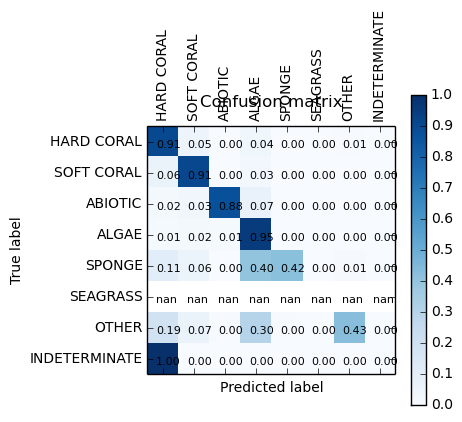

'Coverage: 59.9904808977%'

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import csv
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, classification_report, \
    precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pandas as pd

%matplotlib inline

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #target_names = target_names
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i, cas in enumerate(cm):
        for j, c in enumerate(cas):
            plt.text(j-.2, i+.2, "%.2f" % c, fontsize=8)

    #plt.savefig("confusion.png")
    plt.show()

def plot_precision_recall(precision, recall, thresholds, title):
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

with open('2014predictions.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(row for row in reader)

dataframe = pd.DataFrame(rows)
    
y_true = []
y_pred = []
y_yes_no = []
y_scores = []

def get_label_number(label, classes):
    for the_class in classes:
        if the_class in label:
            return classes.index(the_class)    

groups = ["HARD CORAL", "SOFT CORAL", "ABIOTIC", "ALGAE", "SPONGE", "SEAGRASS", "OTHER", "INDETERMINATE"]
groups_orig = ["HC", "SC", "AB", "A", "SP", "SG", "OT", "IN"]


target_names = groups
chart_labels = groups
label_numbers = [index for index, item in enumerate(chart_labels)]

for row in rows:
    
    original = groups_orig.index(row["GROUP_CODE"])
    prediction = groups.index(row["PREDICTION"])
    predition_score = row["PREDICTION_SCORE"]
    
    y_true.append(original)
    y_pred.append(prediction)
    y_scores.append(float(predition_score))



def plot_dynamic_confusion(prediction_score_threshold=0.9):
        new_y_true = []
        new_y_pred = []
        new_y_scores = []
        
        for index, item in enumerate(y_scores):
            if item >= prediction_score_threshold:
                new_y_true.append(y_true[index])
                new_y_pred.append(y_pred[index])
                new_y_scores.append(y_scores[index])
        
        cm = confusion_matrix(new_y_true, new_y_pred, label_numbers)
        np.set_printoptions(precision=2)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plot_confusion_matrix(cm_normalized, chart_labels)
        
        return "Coverage: " + str( 100 - ((len(y_scores) - len(new_y_scores)) / float(len(y_scores)) * 100.0) ) + "%"

interact(plot_dynamic_confusion, prediction_score_threshold=(0.00, 1.00, 0.001))

In [2]:
#print(dataframe.loc[dataframe['REEF_NAME'] == 'HAVANNAH REEF'])

def tally_reef_stats(reef_name, rows, prediction_score_threshold=0.9):
    correct = 0
    incorrect = 0
    coverage = 0
    
    groups_correct = {}
    groups_incorrect = {}
    
    for row in rows:
        original = groups_orig.index(row["GROUP_CODE"])
        prediction = groups.index(row["PREDICTION"])
        predition_score = float(row["PREDICTION_SCORE"])
        
        if predition_score >= prediction_score_threshold:
            coverage = coverage + 1
            if original == prediction:
                correct = correct + 1
                groups_correct[row["GROUP_CODE"]] = groups_correct.get(row["GROUP_CODE"], 0) + 1
            else:
                incorrect = incorrect + 1
                groups_incorrect[row["GROUP_CODE"]] = groups_incorrect.get(row["GROUP_CODE"], 0) + 1
    
    total = float(correct) / float(correct+incorrect) * 100.0
    coverage = float(coverage) / float(len(rows)) * 100.0
    total = "{0:.2f}".format(total) +"%"
    coverage = "{0:.2f}".format(coverage) +"%"
    #print(reef_name + " " + str(total) + " " + str(coverage))

    summary = {"Reef": reef_name, "Tot Accuracy": total, "Tot Coverage": coverage}
    for key in groups_orig:
        group_incor = groups_incorrect.get(key, 0)
        group_cor = group_incor = groups_correct.get(key, 0)
        if group_incor+group_cor == 0:
            summary[str(key)] = "NA"
        else:
            summary[str(key)] = float(groups_correct.get(key, 0)) / (float(groups_correct.get(key, 0)) + float(groups_incorrect.get(key, 0))) * 100.0
            summary[str(key)] = "{0:.2f}".format(summary[str(key)]) +"%"
    
    return summary

def tally_reefs(prediction_score_threshold=0.9):
    #df = dataframe.sample(frac=0.1)
    
    reefs = dataframe['REEF_NAME'].unique()
    printable = []
    
    for reef in reefs:
        printable.append(tally_reef_stats(reef, dataframe.loc[dataframe['REEF_NAME'] == reef].to_dict('records'), prediction_score_threshold))
        
    new_df = pd.DataFrame(printable)
    new_df = new_df.fillna("NA")
    print(new_df.to_string())
    
interact(tally_reefs, prediction_score_threshold=(0.00, 1.00, 0.001))

         A       AB      HC  IN       OT                       Reef       SC  SG       SP Tot Accuracy Tot Coverage
0   97.47%   90.86%  83.95%  NA       NA              HAVANNAH REEF   54.55%  NA       NA       95.71%       65.25%
1   90.33%   63.92%  89.09%  NA       NA                     21529S  100.00%  NA       NA       86.88%       51.42%
2   96.66%  100.00%  90.50%  NA   50.00%            BROOMFIELD REEF   94.32%  NA       NA       93.48%       63.89%
3   91.04%       NA  87.32%  NA       NA              EAST CAY REEF   81.65%  NA   71.43%       86.75%       56.75%
4   94.65%   50.00%  92.48%  NA       NA           GANNETT CAY REEF   82.35%  NA       NA       93.00%       53.05%
5   98.41%   75.00%  92.34%  NA   12.50%         LADY MUSGRAVE REEF  100.00%  NA       NA       96.53%       70.28%
6   97.26%       NA  83.43%  NA       NA              ONE TREE REEF  100.00%  NA   10.00%       93.91%       60.44%
7   94.57%       NA  96.93%  NA   30.00%              SNAKE (22088)   80

<function __main__.tally_reefs>